In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from scripts import cleansing, eda

random_state=17

In [26]:
path = './data/AmesHousing.txt'

raw = pd.read_table(path, index_col=0)
df = cleansing.data_cleaning(raw)

# need to get read of this
df = df.reset_index().iloc[:, 1:]

First of all, we need to point out one interesting thing in distribution of target variable

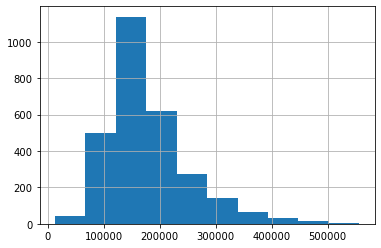

In [27]:
df.SalePrice.hist();

In [54]:
df.SalePrice.sort_values()

173      9.456341
1503     9.480368
2745    10.463103
2781    10.471950
683     10.542706
          ...    
1645    13.122497
354     13.126031
2255    13.190022
2251    13.208952
2253    13.229568
Name: SalePrice, Length: 2830, dtype: float64

As we've already said, we observe heavy tail and distribution isn't symmetrical, which isn't good for fitting. Taking this into consideration, we'll fit our model not to target variable, but to its logarithm.

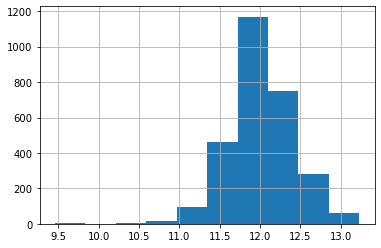

In [28]:
np.log(df.SalePrice).hist();

In [29]:
df['SalePrice'] = np.log(df['SalePrice'])

Let's separate validation data

In [30]:
df_train, df_val = train_test_split(df, test_size=0.2)

And then make folds on train

In [31]:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=random_state)

Let's try first some linear models

In [50]:
scaler = StandardScaler()
model = Ridge(alpha=0.1)
df_train = df_train.sort_index()
y = df_train['SalePrice']
X = df_train.drop('SalePrice', axis=1)
mse_scores = {'cv': [], 'val': 0}
r2_scores = {'cv': [], 'val': 0}

for train, test in rkf.split(X, y):
    y_train, y_test = y.iloc[train], y.iloc[test]
    X_converted = eda.convert_features(pd.concat([X, y_train], axis=1)).drop('SalePrice', axis=1)
    X_train, X_test = X_converted.iloc[train, :], X_converted.iloc[test, :]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train.values)
    y_predict = model.predict(X_test)
    mse_scores['cv'].append(mean_squared_error(y_test.values, y_predict))
    r2_scores['cv'].append(r2_score(y_test.values, y_predict))
print('train CV MSE: ', sum(mse_scores['cv'])/len(mse_scores['cv']))
print('train CV R2: ', sum(r2_scores['cv'])/len(r2_scores['cv']))

y_train, y_val = df_train['SalePrice'], df_val['SalePrice']
X_converted = eda.convert_features(pd.concat([df.iloc[:, :-1], y_train], axis=1)).drop('SalePrice', axis=1)
X_train, X_val = X_converted.loc[df_train.index, :], X_converted.loc[df_val.index, :]
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
model.fit(X_train, y_train.values)
y_predict = model.predict(X_val)
mse_scores['val'] = mean_squared_error(y_val.values, y_predict)
r2_scores['val'] = r2_score(y_val.values, y_predict)
print('val MSE: ', mse_scores['val'])
print('val R2: ', r2_scores['val'])

train CV MSE:  0.014492156173981316
train CV R2:  0.9049326565441852
val MSE:  0.01842721894546382
val R2:  0.8902312870184851


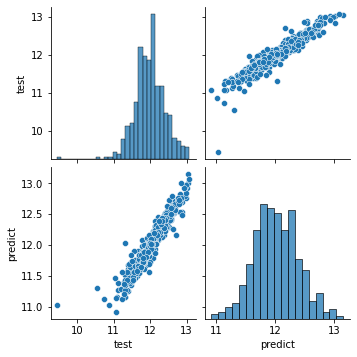

In [52]:
sns.pairplot(data=pd.DataFrame({'test':y_val.values, 'predict':y_predict}));